<a href="https://colab.research.google.com/github/schen304joseph/HW3/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# A simple example of using PyTorch for gradient descent

import torch as t
from torch.autograd import Variable

# Define a variable, make sure requires_grad=True so that PyTorch can take gradient with respect to this variable
x = Variable(t.tensor([1.0, 0.0]), requires_grad=True)

# Define a loss
loss = (x[0] - 1)**2 + (x[1] - 2)**2

# Take gradient
loss.backward()

# Check the gradient. numpy() turns the variable from a PyTorch tensor to a numpy array.
x.grad.numpy()

array([ 0., -4.], dtype=float32)

In [5]:
import torch as t
from torch.autograd import Variable
import math

T=20
def Psat(a1, a2, a3):
 return math.exp(a1-(a2/T+a3))

A = Variable(t.tensor([1.0, 0.0]), requires_grad=True)
#A21 = Variable(t.tensor([1.0, 0.0]), requires_grad=True)
Psatwater = Psat(8.07131,1730.63,233.426)
Psatdiox = Psat(7.43155,1554.679,240.337)
#loss = x[0]*math.exp((A12*(A21*(1-x[0])))/A12*X[0]+A21*(1-x[0]))**2)*Psatwater+(1-x[0])*math.exp((A21/A12*X[0]+A21*(1-x[0]))**2)*Psatdiox
loss = A[0]*math.exp(x[1])

loss.backward()
x.grad.numpy()


NameError: ignored

11
[1.  0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1 0. ]


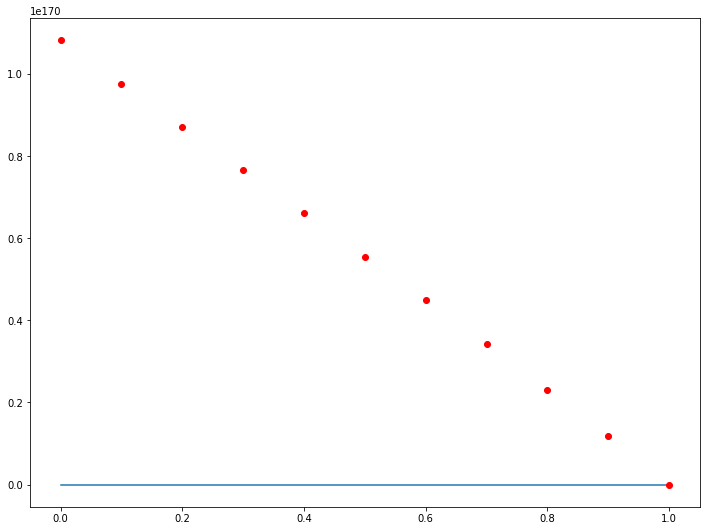

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
plt.rcParams['figure.figsize'] = (12.0,9.0)
x1 = np.arange(start=0, stop=1.1, step=0.1)
x2 = 1-x1

p = np.array([28.1,34.4,36.7,36.9,36.8,36.7,36.5,35.4,32.9,27.7,17.5])
def psat (a1,a2,a3):
  return int(10**(a1-a2/20+a3))
def pval (x1,x2,A12,A21):
  return x1*np.exp(A12*((A21*x2)/(A12*x1+A21*x2))**2)*psat(8.07131,1730.63,233.426)+x2*np.exp(A21*((A12*x1)/(A12*x1+A21*x2))**2)*psat(7.43155,1554.679,240.337)
#def pval (x1,x2,A12,A21):
  #return x1*np.exp(A12((A21*x2))
Aguess = [0.1,0.1]
plt.plot(x1,p)

n=len(x1)
y=np.empty(n)
for i in range(n):
  y[i]=pval(x1[i],x2[i],Aguess[0],Aguess[1])
plt.plot(x1,y,'ro')
print(len(x1))
print(x2)

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import lsq_linear

plt.rcParams['figure.figsize'] = (12.0,9.0)
x1 = np.arange(start=0, stop=1.1, step=0.1)
x2 = 1-x1
p = np.array([28.1,34.4,36.7,36.9,36.8,36.7,36.5,35.4,32.9,27.7,17.5])

def psat (a1,a2,a3):
  return int(10**(a1-a2/20+a3))

def pval (x1,x2,A12,A21):
  return x1*np.exp(A12*((A21*x2)/(A12*x1+A21*x2))**2)*psat(8.07131,1730.63,233.426)+x2*np.exp(A21*((A12*x1)/(A12*x1+A21*x2))**2)*psat(7.43155,1554.679,240.337)

Aguess = [0.1,0.1]
plt.plot(x1,p)


c,cov = lsq_linear(pval,x1,p,bounds=([-np.inf, 1.5])

n = len(x1)
y=np.empty(n)
for i in range(n):
  y[i]=pval(x1[i],x2[i],c[0],c[1])

plt.plot(x1,y,'ro')


SyntaxError: ignored

In [45]:
x1 = np.arange(start=0, stop=1.1, step=0.1)
x2 = 1-x1
Aguess = [10,11]
Aguess[0]

10